## Analyze A/B Test Results

[RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project analyses the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` **Quiz 1**: Understanding the dataset.

Read the `ab_data.csv` data and store it in `df`.


a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [5]:
df[df['converted']==1].count()[0]/df.count()[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df['landing_page'].value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [7]:
df[(df['group']=='treatment') &  (df['landing_page']!='new_page') ].count()[0] + \
    df[(df['group']!='treatment') &  (df['landing_page']=='new_page') ].count()[0]

3893

f. Do any of the rows have missing values? 
<font color='blue'>No</font> 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` **Quiz 2**: Messy data.

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  <font color='blue'>To handle these we can remove this rows.</font>  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2=df[(df['group']=='treatment') &  (df['landing_page']=='new_page') ]
df2=df2.append(df[(df['group']=='control') &  (df['landing_page']=='old_page') ])
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` **Quiz 3**: Updated DataFrame **df2**.

a. How many unique **user_id**s are in **df2**?

In [11]:
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(1899, inplace=True)
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` **Quiz 4**: Probability.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2[df2['converted']==1].count()[0]/df2.count()[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[(df2['converted']==1)& (df2['group']=='control')].count()[0]/df2[df2['group']=='control'].count()[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[(df2['converted']==1)& (df2['group']=='treatment')].count()[0]/df2[df2['group']=='treatment'].count()[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2[df2['landing_page']=='new_page'].count()[0]/df2.count()[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

<font color='blue'> As we saw above the **new page** is given to the users with probability of 50%. Furthermore, we checked that independently of the group (**treatment** or **control**) user is converted with probability of about 12%, which is approximately equal to overal conversion provavility. Thus we don't have evidence that one page leads to more conversions that other.</font>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<font color='blue'> 
$H_{0}: p_{new} - p_{old} <=0$

$H_{1}: p_{new} -  p_{old} > 0$
</font>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [19]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0


a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new=df2[(df2['converted']==1)].count()[0]/df2.count()[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old=df2[ (df2['converted']==1)].count()[0]/df2.count()[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new=df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old=df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted=np.random.choice([0,1], n_new, p=(1-p_new, p_new))
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted=np.random.choice([0,1], n_old, p=(1-p_old, p_old))
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff_obs=new_page_converted.mean()-old_page_converted.mean()
diff_obs

-0.00021573892522935845

In [27]:
new_page_converted.sum()/n_new-old_page_converted.sum()/n_old

-0.00021573892522935845

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

**numpy.random.binomial(n, p, size=None)**
Draw samples from a binomial distribution.

Samples are drawn from a binomial distribution with specified parameters, n trials and p probability of success where n an integer >= 0 and p is in the interval [0,1]. (n may be input as a float, but it is truncated to an integer in use)







In [28]:
p_diffs = np.random.binomial(n_new, p_new, 10000)/n_new - np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs

array([-0.00040854, -0.00085569,  0.00012853, ...,  0.00078952,
        0.00078244, -0.00116496])

i. Plot a histogram of the **p_diffs**.  <font color='blue'>Looks like normal distriburion.</font>

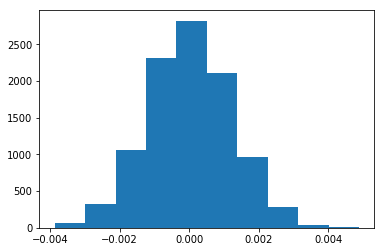

In [29]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

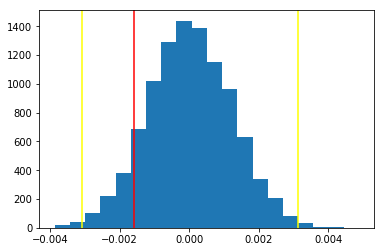

In [30]:
# observed difference on cleaned data
diff_obs=df2[ df2['group']== 'treatment']['converted'].mean()-df2[ df2['group']== 'control']['converted'].mean()

plt.hist(p_diffs, bins=20);
plt.axvline(x=diff_obs, color='red');
# view 99% confidence interval
low, upper = np.percentile(p_diffs, .5), np.percentile(p_diffs, 99.5)
plt.axvline(x=low, color='yellow');
plt.axvline(x=upper, color='yellow');

In [31]:
# calculate p-value
sum(p_diffs>diff_obs)/10000

0.9097

In [32]:
(p_diffs>diff_obs).mean()

0.9097

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


<font color='blue'> In part **j** we generated the p-value. P-value is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be greater than or equal to the actual observed results.

A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so  reject the null hypothesis.

A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

In our case p-value is about 0.9, thus we **fail to reject the null hypotesis** that the old page is better or the same as the new one.</font>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page']=='old_page')]['converted'].sum()
n_old=df2[df2['landing_page']=='old_page'].count()[0]
 
convert_new = df2[(df2['landing_page']=='new_page')]['converted'].sum()
n_new=df2[df2['landing_page']=='new_page'].count()[0]

print (convert_old, n_old, convert_old/n_old)
print (convert_new, n_new, convert_new/n_new)

17489 145274 0.1203863045004612
17264 145310 0.11880806551510564


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

<font color='blue'>

Proportions_ztest is checking if two proportions are statistically better-than (one-tail test), worse-than (one-tail test), or different from (two-tail test) each other.

statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False) 

Value is 0 by default.

By default it uses two-sided test, however we will need right sided test or 'smaller'. Smaller means that the alternative hypothesis is $H_1: p_{old}-p_{new}<0$. </font>

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [35]:
from scipy.stats import norm

norm.cdf(z_score)
 # Tells us how significant our z-score is

0.9050583127590245

In [36]:
norm.ppf(1-(0.05/2))
# Tells us what our critical value at 95% confidence is

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<font color='blue'>
A Z-test is any statistical test for which the distribution of the test statistic under the null hypothesis can be approximated by a normal distribution. The z-score is the distance from the sample mean to the population mean. the same as above with high p-value we fail to reject null hypothesis.
    </font>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color='blue'>
Logistic regression. </font>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#df2[df2['group']=='control']

In [38]:
df2[['control','ab_group']]=pd.get_dummies(df2['group'])
df2.tail(5)

,user_id,timestamp,group,landing_page,converted,control,ab_group
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0


In [39]:
df2['intercept']=1
df2.head(5)

,user_id,timestamp,group,landing_page,converted,control,ab_group,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
mod=sm.Logit(df2.converted, df2[['intercept', 'ab_group']])
res=mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:56:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_group      -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? <font color='blue'> P-value for ab_group is 0.19 and higher than 0.05 that shows us that the landing page is not statistically significant in predicting conversions. Intercept (in this case equivalent to the old page) has p-value of 0.0 and is statistically significant in predicting the conversions </font>

Why does it differ from the value you found in the **Part II**? <font color='blue'> P-value simulated earlier in this notebook was about 0.9
    
For the regresssion the null hypotesis is $H_{0}: p_{new} = p_{old}$ and $H_{1}: p_{new} \neq  p_{old} $, so we have two-tailed test, when previously it was right-tailed</font>

In [42]:
1/np.exp(-0.0150)

1.015113064615719

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='blue'>

It might be a good idea to add some additional factors in the regression mode, such as time of a day, day of a week to improve predictivity. Furthermore, maybe user_id number can tell us more about user itself. Other option is to add higher order terms, but for the landing page which is categorial data it will not improve the fitting model. 

Disadvantage is that we have to check if our factors are independed from each other and the new higher order terms or cross terms are not so obviouse in interpritation. </font>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [43]:
# read countries data
country_df=pd.read_csv('countries.csv')
country_df.head(5)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# merge two dataframes
df2=df2.merge(country_df, how='left', left_on='user_id', right_on='user_id')
df2.head(5)

,user_id,timestamp,group,landing_page,converted,control,ab_group,intercept,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,1,CA


In [45]:
# check if there is NaN values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 9 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
control         290584 non-null uint8
ab_group        290584 non-null uint8
intercept       290584 non-null int64
country         290584 non-null object
dtypes: int64(3), object(4), uint8(2)
memory usage: 18.3+ MB


In [46]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
# add dummy columns for country, above we saw that there are only 3 contries
df2=df2.join(pd.get_dummies(df2['country']))
df2.head(5)

,user_id,timestamp,group,landing_page,converted,control,ab_group,intercept,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,1,CA,1,0,0


In [48]:
mod=sm.Logit(df2.converted, df2[['intercept',  'UK', 'US']])
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Dec 2018   Pseudo R-squ.:               1.521e-05
Time:                        16:56:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.

In [49]:
np.exp(0.0507), np.exp(0.0408)

(1.052007243765014, 1.0416437559600236)

<font color='blue'>The p-value for the countries (UK, US) is higher then 0.05, so countries are not statistically significant in predicting conversions.

For the UK user conversion is 1.052 times as likely, holding all else constant.

For the US user conversion is 1.042 times as likely, holding all else constant.</font>

In [50]:
mod=sm.Logit(df2.converted, df2[['intercept', 'ab_group','UK', 'US']])
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        16:56:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_group      -0.0149      0.

In [51]:
1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

<font color='blue'>Again all p-values are higher than 0.05. 
</font>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
# creating new columns
df2['ab_UK']=df2['ab_group']*df2['UK']
df2['ab_US']=df2['ab_group']*df2['US']
df2.head(5)

,user_id,timestamp,group,landing_page,converted,control,ab_group,intercept,country,CA,UK,US,ab_UK,ab_US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,1,CA,1,0,0,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,1,UK,0,1,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,1,CA,1,0,0,0,0


In [53]:
mod=sm.Logit(df2.converted, df2[['intercept', 'ab_group','UK','ab_UK', 'US', 'ab_US']])
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 27 Dec 2018   Pseudo R-squ.:               3.482e-05
Time:                        16:56:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_group      -0.0674      0.

In [54]:
1/np.exp(-0.0674), np.exp(0.0118), np.exp(0.0783), np.exp(0.0175), np.exp(0.0469)

(1.0697232819209153,
 1.011869894648401,
 1.0814470441230692,
 1.0176540221507617,
 1.048017202119183)

<font color='blue'>Again we see that all p-values are higher than 0.05, so none of the parameters are significant.</font>

### Conclusions: 
<font color='blue'>
we can't reject the null hypothesis, or we might need to use other parameters (not only landing page and country) for better prediction. </font>

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0